In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05c Single Cell Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05c Single Cell Dataset Benchmarker.ipynb"
dataset_name = "bone marrow"
sigma = 'automatic'
flow_strength = 5
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 10
diffdist_weight = 1
num_neighbors = 20

In [ ]:
# Parameters
notebook = "05c Single Cell Dataset Benchmarker.ipynb"
dataset_name = "dentategyrus"
sigma = "automatic"
flow_strength = 5
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 5
diffdist_weight = 1
num_neighbors = 10
output_label = "run_1"


# Set Up

Normalized count data: X, spliced, unspliced.
Logarithmized X.


computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding


    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
Set sigma =  4.1423225


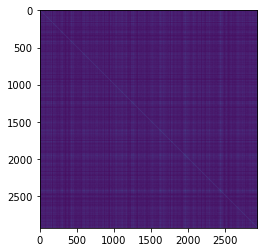

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
# choose correct dataset
if dataset_name == "bone marrow":
    adata = scv.datasets.bonemarrow()
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
elif dataset_name == "dentategyrus":
    adata = scv.datasets.dentategyrus()
    X, flow, labels, n_pcs = rnavelo_pcs(adata)

# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

In [ ]:
X.shape

torch.Size([2930, 30])

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[30, 20, 10, 5, 2],
            device=device,
            sigma=1,
            flow_strength=5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "distance regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=50)

  0%|                                                                                             | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                   | 1/50 [00:07<06:01,  7.37s/it]

  4%|███▍                                                                                 | 2/50 [00:13<05:32,  6.93s/it]

  6%|█████                                                                                | 3/50 [00:20<05:19,  6.79s/it]

  8%|██████▊                                                                              | 4/50 [00:27<05:07,  6.68s/it]

 10%|████████▌                                                                            | 5/50 [00:33<05:00,  6.67s/it]

 12%|██████████▏                                                                          | 6/50 [00:40<04:52,  6.66s/it]

 14%|███████████▉                                                                         | 7/50 [00:47<04:47,  6.69s/it]

 16%|█████████████▌                                                                       | 8/50 [00:53<04:42,  6.73s/it]

 18%|███████████████▎                                                                     | 9/50 [01:00<04:37,  6.76s/it]

 20%|████████████████▊                                                                   | 10/50 [01:07<04:31,  6.78s/it]

 22%|██████████████████▍                                                                 | 11/50 [01:14<04:24,  6.77s/it]

 24%|████████████████████▏                                                               | 12/50 [01:21<04:18,  6.80s/it]

 26%|█████████████████████▊                                                              | 13/50 [01:28<04:11,  6.80s/it]

 28%|███████████████████████▌                                                            | 14/50 [01:35<04:06,  6.86s/it]

 30%|█████████████████████████▏                                                          | 15/50 [01:42<04:01,  6.91s/it]

 32%|██████████████████████████▉                                                         | 16/50 [01:48<03:54,  6.91s/it]

 34%|████████████████████████████▌                                                       | 17/50 [01:55<03:46,  6.87s/it]

 36%|██████████████████████████████▏                                                     | 18/50 [02:02<03:39,  6.86s/it]

 38%|███████████████████████████████▉                                                    | 19/50 [02:09<03:33,  6.87s/it]

 40%|█████████████████████████████████▌                                                  | 20/50 [02:16<03:26,  6.88s/it]

 42%|███████████████████████████████████▎                                                | 21/50 [02:23<03:17,  6.82s/it]

 44%|████████████████████████████████████▉                                               | 22/50 [02:29<03:10,  6.80s/it]

 46%|██████████████████████████████████████▋                                             | 23/50 [02:36<03:03,  6.78s/it]

 48%|████████████████████████████████████████▎                                           | 24/50 [02:43<02:56,  6.77s/it]

 50%|██████████████████████████████████████████                                          | 25/50 [02:49<02:48,  6.75s/it]

 52%|███████████████████████████████████████████▋                                        | 26/50 [02:56<02:41,  6.73s/it]

 54%|█████████████████████████████████████████████▎                                      | 27/50 [03:03<02:34,  6.72s/it]

 56%|███████████████████████████████████████████████                                     | 28/50 [03:10<02:27,  6.72s/it]

 58%|████████████████████████████████████████████████▋                                   | 29/50 [03:16<02:20,  6.69s/it]

 60%|██████████████████████████████████████████████████▍                                 | 30/50 [03:23<02:13,  6.66s/it]

 62%|████████████████████████████████████████████████████                                | 31/50 [03:29<02:06,  6.64s/it]

 64%|█████████████████████████████████████████████████████▊                              | 32/50 [03:36<01:59,  6.62s/it]

 66%|███████████████████████████████████████████████████████▍                            | 33/50 [03:43<01:52,  6.61s/it]

 68%|█████████████████████████████████████████████████████████                           | 34/50 [03:49<01:45,  6.60s/it]

 70%|██████████████████████████████████████████████████████████▊                         | 35/50 [03:56<01:39,  6.60s/it]

 72%|████████████████████████████████████████████████████████████▍                       | 36/50 [04:02<01:32,  6.63s/it]

 74%|██████████████████████████████████████████████████████████████▏                     | 37/50 [04:09<01:26,  6.64s/it]

 76%|███████████████████████████████████████████████████████████████▊                    | 38/50 [04:16<01:19,  6.64s/it]

 78%|█████████████████████████████████████████████████████████████████▌                  | 39/50 [04:22<01:12,  6.63s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 40/50 [04:29<01:06,  6.61s/it]

 82%|████████████████████████████████████████████████████████████████████▉               | 41/50 [04:36<00:59,  6.59s/it]

 84%|██████████████████████████████████████████████████████████████████████▌             | 42/50 [04:42<00:52,  6.58s/it]

 86%|████████████████████████████████████████████████████████████████████████▏           | 43/50 [04:49<00:45,  6.56s/it]

 88%|█████████████████████████████████████████████████████████████████████████▉          | 44/50 [04:55<00:39,  6.53s/it]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 45/50 [05:02<00:32,  6.52s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▎      | 46/50 [05:08<00:26,  6.53s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▉     | 47/50 [05:15<00:20,  6.74s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▋   | 48/50 [05:22<00:13,  6.67s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [05:28<00:06,  6.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:35<00:00,  6.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:35<00:00,  6.71s/it]

# Results

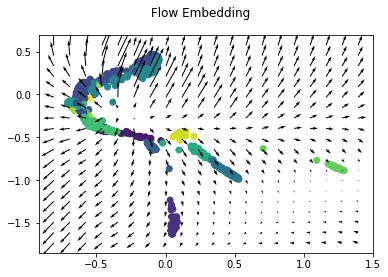

In [ ]:
FREDtrainer.visualize_embedding()

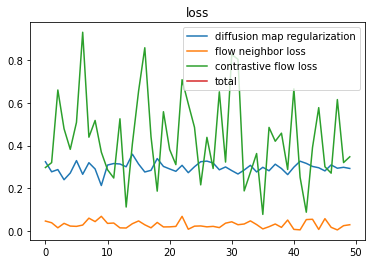

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYcAAP///////f//+///+v//+P//9v//9P//7v//2v7///7//fz///…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

(2930, 4)

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

## SCORES ## 
 silhouette score w/o flows: 0.17831064760684967.
 silhouette score w/ flows:  0.17458035051822662 
 kNN Classifier 0.8510858324715616


# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

'3N2zmWLwzO4WDWWS6L8h'

In [ ]:
import csv
spread_name = notebook.replace('.ipynb','') + "_dataset_" + dataset_name
print(spread_name)
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid, 
         sigma, 
         flow_strength, 
         flow_neighbor_loss_weight,
         contrastive_flow_loss_weight,
         smoothness_weight, 
         diffdist_weight, 
         num_neighbors,
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 

05c Single Cell Dataset Benchmarker_dataset_dentategyrus
